In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [2]:
url = 'https://www.worldometers.info/coronavirus/'
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
_dict = {}
save_csv = True
append_csv = True

In [3]:
page = requests.get(url)
soup = BeautifulSoup(page.content)

In [4]:
for _tr_list in soup.tbody.find_all('tr'):
    _td_list = _tr_list.find_all('td')
    for i, _td in enumerate(_td_list):        
        # Recuperar el nombre del pais cuando es un enlace
        if i%9 == 0:
            _a = _td.find('a')
                # Recuperar el nombre del pais cuando es un enlace
            if _a:
                country_name = _a['href'].split('/')[1]
            else:
                _span = _td.find('span')
                if _span:
                    # Recuperar el nombre del cuando ocupa dos filas
                    country_name = _span.contents[0]
                else:
                     # Recuperar el nombre del pais cuando no es un enlace
                    country_name = _td.contents[0]
            if country_name:
                country_name = country_name.strip()
                if country_name not in list(_dict.keys()):
                    _dict[country_name] = {} 
                _dict[country_name][now] = []
        # Recuperar los datos del pais
        else:
            if len(_td.contents) > 0:
                # Limipiar el dato de cualquier símbolo para poder convertirlo en un valor numérico
                data = _td.contents[0].replace('+','').replace(',','').strip()
                if data:
                    _dict[country_name][now].append(float(data))
                else:
                    _dict[country_name][now].append(0)
            else:
                _dict[country_name][now].append(0)

In [5]:
# https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
df = pd.concat({k: pd.DataFrame(v).T for k, v in _dict.items()}, axis=0)
df.columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_recovered', 'active_cases', 'servious_critical', 'total_cases_1M_pop']
df.index.names = ['country', 'timestamp']
display(df.head())

,,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
country,timestamp,,,,,,,,
Afghanistan,2020-03-21 12:52:06,24.0,0.0,0.0,0.0,1.0,23.0,0.0,0.60
Albania,2020-03-21 12:52:06,76.0,6.0,2.0,0.0,2.0,72.0,2.0,26.00
Andorra,2020-03-21 12:52:06,88.0,13.0,0.0,0.0,1.0,87.0,2.0,1139.00
Angola,2020-03-21 12:52:06,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.06
Antigua and Barbuda,2020-03-21 12:52:06,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.00


In [6]:
if save_csv:
    if append_csv:
        print('Adding data to csv...')
        df.to_csv('covid-19_2020.csv', mode='a', header=False, index=True) 
    else:
        print('Creating csv...')
        df.to_csv('covid-19_2020.csv', index=True)    
else:
    print('Save csv not needed')

Adding data to csv...


In [7]:
df = pd.read_csv('covid-19_2020.csv')

In [8]:
df.head()

,country,timestamp,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
0,Afghanistan,2020-03-19 19:12:43,22.0,0.0,0.0,0.0,1.0,21.0,0.0,0.6
1,Albania,2020-03-19 19:12:43,64.0,5.0,2.0,0.0,0.0,62.0,2.0,22.0
2,Algeria,2020-03-19 19:12:43,90.0,15.0,9.0,2.0,32.0,49.0,0.0,2.0
3,Andorra,2020-03-19 19:12:43,53.0,0.0,0.0,0.0,1.0,52.0,0.0,686.0
4,Antigua and Barbuda,2020-03-19 19:12:43,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0


In [9]:
# Solo paises más significativos
df_significant = df[(df['total_cases'] > 5000)].sort_values(by = ['timestamp', 'total_cases'], ascending=False)

# Se muestra el número de casos según el país ("country") para la última muestra
last_timestamp = list(df_significant['timestamp'])[0]
df_last_timestamp = df_significant[(df_significant['timestamp'] == last_timestamp)]
display(df_last_timestamp)

,country,timestamp,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
1080,china,2020-03-21 12:52:06,81008.0,41.0,3255.0,7.0,71740.0,6013.0,1927.0,56.0
1090,italy,2020-03-21 12:52:06,47021.0,0.0,4032.0,0.0,5129.0,37860.0,2655.0,778.0
1098,spain,2020-03-21 12:52:06,24926.0,3355.0,1326.0,233.0,2125.0,21475.0,939.0,533.0
1087,iran,2020-03-21 12:52:06,20610.0,966.0,1556.0,123.0,7635.0,11419.0,0.0,245.0
1084,germany,2020-03-21 12:52:06,20581.0,733.0,72.0,4.0,209.0,20300.0,2.0,246.0
1102,us,2020-03-21 12:52:06,19775.0,392.0,276.0,20.0,147.0,19352.0,64.0,60.0
1083,france,2020-03-21 12:52:06,12612.0,0.0,450.0,0.0,1587.0,10575.0,1297.0,193.0
1097,south-korea,2020-03-21 12:52:06,8799.0,147.0,102.0,8.0,2612.0,6085.0,59.0,172.0
1100,switzerland,2020-03-21 12:52:06,5712.0,97.0,58.0,2.0,15.0,5639.0,141.0,660.0


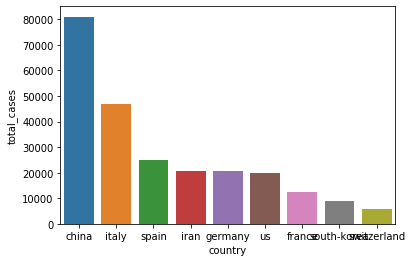

In [10]:
# Se representan gráficamente los resultados
# https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
plot = sns.barplot(x="country", y="total_cases", data=df_last_timestamp)

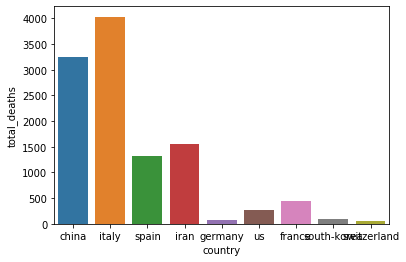

In [11]:
plot = sns.barplot(x="country", y="total_deaths", data=df_last_timestamp)

In [12]:
df_significant = df_significant

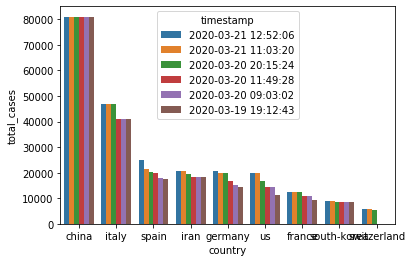

In [13]:
# Se muestra la evolución en el tiempo para cada país ("country")
# Se representan gráficamente los resultados
# 
plot = sns.barplot(x="country", y="total_cases", hue = "timestamp", data=df_significant)

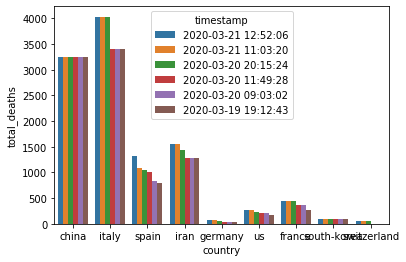

In [14]:
plot = sns.barplot(x="country", y="total_deaths", hue = "timestamp", data=df_significant)

In [15]:
df_spain = df_significant[(df_significant['country'] == 'spain')]

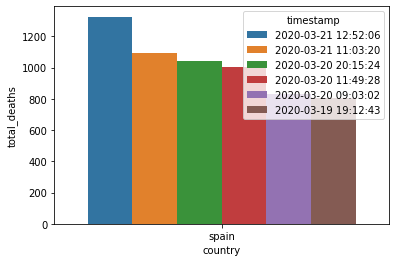

In [16]:
plot = sns.barplot(x="country", y="total_deaths", hue = "timestamp", data=df_spain)